# Upload training file and necessary preprocessing

In [1]:
from google.colab import files
uploaded = files.upload()

Saving EXIST2023_training.json to EXIST2023_training.json


## Pre-Requisits

In [ ]:
!pip install langdetect
!pip install -q -U "tensorflow-text==2.11.*"
!pip install -q tf-models-official==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Json file into dataframe

In [161]:
# from langdetect import detect
import pandas as pd
import numpy as np

df = pd.read_json("EXIST2023_training.json")

## Preparing the dataset 

In [162]:
tweets = []
labels = []
sexism = []
tLabels = []
sLabels = []
otherLang = 0
english = 0
id = []
sexId = []

for i in df:  
  countY = 0
  countN = 0

  # if detect(df[i].tweet) == 'en':
  #   english +=1
  # else:
  #   otherLang +=1
  #   continue

  if i < 200000:
    continue
  id.append(int(i))
  # print(detect(df[i].tweet))
  tweets.append(df[i].tweet)
  for j in df[i].gender_annotators:
    # print(j)
    pass
  for k in df[i].age_annotators:
    # print(k)
    pass

  for l in df[i].labels_task1:
    if l == 'YES':
      countY +=1
    if l == 'NO':
      countN +=1
  if countY == countN :
    labels.append(-1)
  elif countY > countN:
    labels.append(1)
    sexId.append(i)
    sexism.append(df[i].tweet)
    tune = {
        "REPORTED": 0, "JUDGEMENTAL": 0, "DIRECT": 0
    }
    sense = {
        "MISOGYNY-NON-SEXUAL-VIOLENCE":0,
        "IDEOLOGICAL-INEQUALITY": 0, 
        "STEREOTYPING-DOMINANCE": 0, 
        "OBJECTIFICATION": 0, 
        "SEXUAL-VIOLENCE":0, 
        "-1":0
    }
    for m in df[i].labels_task2:
      if m == 'REPORTED':
        tune["REPORTED"] +=1
      if m == 'JUDGEMENTAL':
        tune["JUDGEMENTAL"] +=1
      if m == 'DIRECT':
        tune["DIRECT"] +=1 
    tLabels.append(max(tune, key=tune.get))

    for n in df[i].labels_task3:

      if n[0] == 'MISOGYNY-NON-SEXUAL-VIOLENCE':
        sense["MISOGYNY-NON-SEXUAL-VIOLENCE"] +=1
      if n[0] == 'IDEOLOGICAL-INEQUALITY':
        sense["IDEOLOGICAL-INEQUALITY"] +=1
      if n[0] == 'STEREOTYPING-DOMINANCE':
        sense["STEREOTYPING-DOMINANCE"] +=1
      if n[0] == 'OBJECTIFICATION':
        sense["OBJECTIFICATION"] +=1
      if n[0] == 'SEXUAL-VIOLENCE':
        sense["SEXUAL-VIOLENCE"] +=1
      if n[0] == '-':
        sense["-1"] +=1

    sLabels.append(max(sense, key=sense.get))
  else:
    labels.append(0)


# print("English tweets ", english)
# print("Other tweets ", otherLang)

## Put the dataset into dataframe

In [163]:
df_tweets = pd.DataFrame(
    {'id': id,
     'tweets': tweets,
    })

df_sexism = pd.DataFrame(
    {'id': sexId,
     'sexism': sexism,
    })




## Preprocessing the Tweets

In [138]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def data_cleansing(tweet):  
    
    # removal of extra spaces
    re_pattern = re.compile(r'\s+')
    spaceRefined = tweet.str.replace(re_pattern, ' ')

    # removal of @name[mention]
    re_pattern = re.compile(r'@[\w\-]+')
    usernameRefined = spaceRefined.str.replace(re_pattern, '')

    # removal of links[https://abc.com]
    re_pattern =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = usernameRefined.str.replace(re_pattern, '')
    
    # removal of punctuations and numbers
    puncRefined = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet = puncRefined.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet = newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
refinedTweets = data_cleansing(df_tweets.tweets)   
df_tweets['processed_tweets'] = refinedTweets
print(df_tweets[["tweets","processed_tweets"]].head(10))

In [ ]:
refinedTweets = data_cleansing(df_sexism.sexism)   
df_sexism['processed_tweets'] = refinedTweets
print(df_sexism[["sexism","processed_tweets"]].head(10))

## Putting the labels into dataframe

In [166]:
df_sexism['label'] = sLabels
df_tweets['label'] = labels

# Visualization of all tweets in the dataset and Sexism Tweets

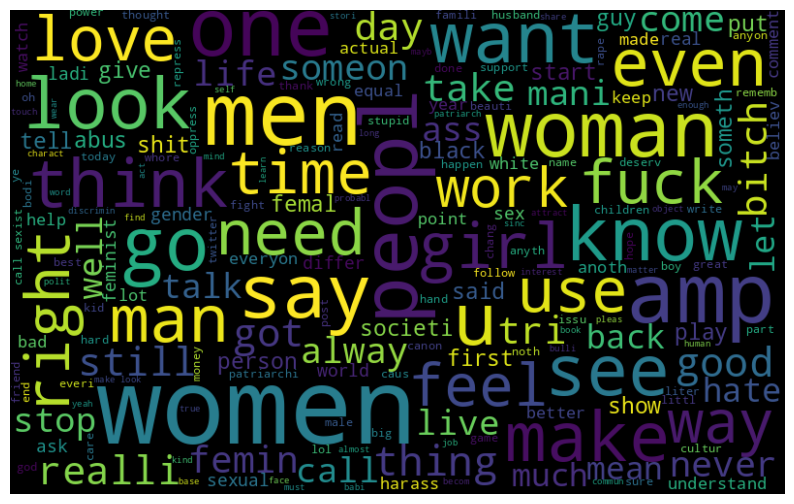

In [167]:
# visualizing which of the word is most commonly used in the dataset
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = ' '.join([word for word in df_tweets['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

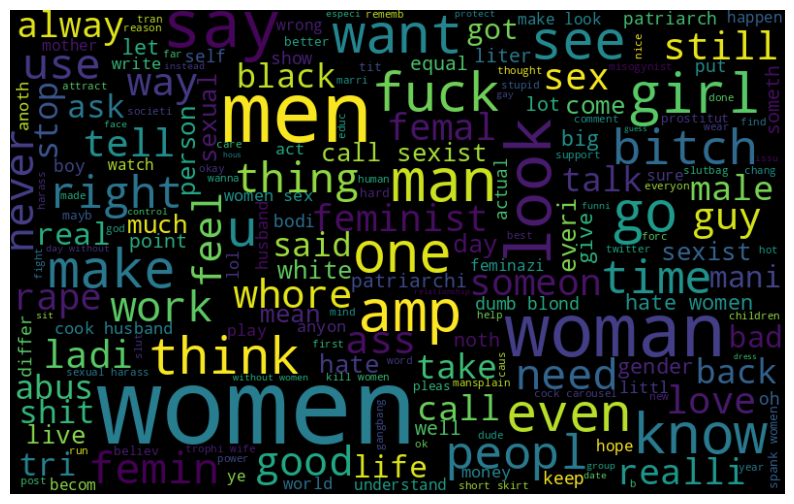

In [168]:
# visualizing which of the word is most commonly used in the dataset
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = ' '.join([word for word in df_sexism['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Preparing dataset labels for Machine Learning Algorithms

In [169]:
df_tweets = df_tweets[df_tweets['label'] != -1]
df_tweets['label'].value_counts()

0    1733
1    1137
Name: label, dtype: int64

In [170]:
df_sexism = df_sexism[df_sexism['label'] != "-1"]
df_sexism['label'].value_counts()

IDEOLOGICAL-INEQUALITY          405
STEREOTYPING-DOMINANCE          287
OBJECTIFICATION                 203
MISOGYNY-NON-SEXUAL-VIOLENCE    119
SEXUAL-VIOLENCE                 102
Name: label, dtype: int64

In [171]:
df_sexism['label']=df_sexism['label'].replace('IDEOLOGICAL-INEQUALITY', 0)
df_sexism['label']=df_sexism['label'].replace('STEREOTYPING-DOMINANCE', 1)
df_sexism['label']=df_sexism['label'].replace('OBJECTIFICATION', 2)
df_sexism['label']=df_sexism['label'].replace('MISOGYNY-NON-SEXUAL-VIOLENCE', 3)
df_sexism['label']=df_sexism['label'].replace('SEXUAL-VIOLENCE', 4)

df_sexism['label'].value_counts()

0    405
1    287
2    203
3    119
4    102
Name: label, dtype: int64

## Word Embedding using TF-IDF

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(df_tweets['processed_tweets'])

print(tfidf.shape)

X = tfidf
y = df_tweets['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

(2870, 1644)


# Task 1: Sexism Detection

### Logistic Regression

In [173]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )

print(report)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       179
           1       0.78      0.56      0.66       108

    accuracy                           0.78       287
   macro avg       0.78      0.73      0.75       287
weighted avg       0.78      0.78      0.77       287



### Support Vector Machine

In [174]:
from sklearn.svm import LinearSVC

support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
# acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
# print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       179
           1       0.73      0.64      0.68       108

    accuracy                           0.78       287
   macro avg       0.77      0.75      0.76       287
weighted avg       0.77      0.78      0.77       287



### Random Forest

In [175]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
# acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
# print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       179
           1       0.77      0.67      0.71       108

    accuracy                           0.80       287
   macro avg       0.79      0.77      0.78       287
weighted avg       0.80      0.80      0.79       287



## Result Generation

In [187]:
result_Task1_Both_Labels = [] 
for id, tweets in df_tweets.iterrows():
  Test = tfidf_vectorizer.transform(np.array([str(tweets['processed_tweets'])]))
  hardLabel = rf.predict(Test)
  softLabel = rf.predict_proba(Test)
  

  sub = {
      str(tweets.id):
      {
        "Hard Label": "Yes" if hardLabel[0] == 1 else "NO",
        "Soft Label": {"Yes":softLabel[0][1], "No": softLabel[0][0] }
      }
  }
  result_Task1_Both_Labels.append(sub)

In [ ]:
import json

with open('Task1Result.json', 'w') as f:
  json.dump(result_Task1_Both_Labels ,f)


In [49]:
import pickle
pickle.dump(rf, open('randomForest.pkl', 'wb'))

In [81]:
pickled_model = pickle.load(open('randomForest.pkl', 'rb'))
y_preds = pickled_model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       353
           1       0.73      0.71      0.72       221

    accuracy                           0.79       574
   macro avg       0.78      0.77      0.77       574
weighted avg       0.79      0.79      0.79       574



# Task 3: Sexism Categorization


## Logistic Regression 

In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(df_sexism['processed_tweets'])

print(tfidf.shape)

X = tfidf
y = df_sexism['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

(1116, 730)


In [204]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )

print(report)

              precision    recall  f1-score   support

           0       0.56      0.78      0.65        41
           1       0.35      0.44      0.39        25
           2       0.60      0.33      0.43        27
           3       0.71      0.36      0.48        14
           4       0.00      0.00      0.00         5

    accuracy                           0.51       112
   macro avg       0.45      0.38      0.39       112
weighted avg       0.52      0.51      0.49       112



## Generating Results

In [218]:
task3_Sexism_Category = list()

for id, sexism in df_sexism.iterrows():
  Test = tfidf_vectorizer.transform(np.array([str(sexism['processed_tweets'])]))
  hardLabel = model.predict(Test)
  softLabel = model.predict_proba(Test)

  sub = {
      str(sexism.id):
      {
        "Hard Label": "IDEOLOGICAL-INEQUALITY" if hardLabel[0] == 0 else "STEREOTYPING-DOMINANCE" if hardLabel[0] == 1 else "OBJECTIFICATION" if hardLabel[0] == 2 else "MISOGYNY-NON-SEXUAL-VIOLENCE" if hardLabel[0] == 3 else "SEXUAL-VIOLENCE",
        "Soft Label": {"IDEOLOGICAL-INEQUALITY":round(softLabel[0][0],3), "STEREOTYPING-DOMINANCE": round(softLabel[0][1],3), "OBJECTIFICATION": round(softLabel[0][2],3), "MISOGYNY-NON-SEXUAL-VIOLENCE": round(softLabel[0][3],3), "SEXUAL-VIOLENCE": round(softLabel[0][3],3) }
      }
  }

  task3_Sexism_Category.append(sub)

  

In [221]:
import json

with open('Task3Result.json', 'w') as f:
  json.dump(task3_Sexism_Category ,f)

## Feeding Sexism to Bert Classifier

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(df_sexism.sexism)
y = np.array(df_sexism['label'].astype(int))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(X_test))
print(tf.sigmoid(bert_raw_result))

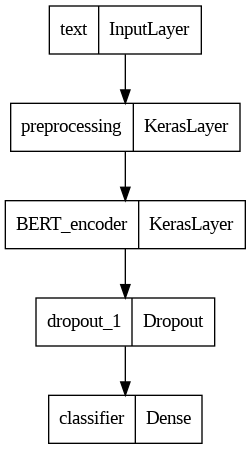

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.binary_accuracy

In [ ]:
epochs = 5
steps_per_epoch = 10
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train,y_train,epochs=epochs)

# history = classifier_model.fit(X_train, y_train, epochs=2, batch_size=32)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
28/28 [==============================] - 181s 6s/step - loss: -3.0724 - binary_accuracy: 0.2537
Epoch 2/5
28/28 [==============================] - 178s 6s/step - loss: -4.1377 - binary_accuracy: 0.2537
Epoch 3/5
28/28 [==============================] - 176s 6s/step - loss: -4.3023 - binary_accuracy: 0.2537
Epoch 4/5
28/28 [==============================] - 184s 7s/step - loss: -4.2834 - binary_accuracy: 0.2537
Epoch 5/5
28/28 [==============================] - 178s 6s/step - loss: -4.3324 - binary_accuracy: 0.2537


In [ ]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

7/7 [==============================] - 13s 2s/step - loss: -3.9738 - binary_accuracy: 0.2703
Loss: -3.9737887382507324
Accuracy: 0.2702702581882477
